## Paquid Data Test

In [ ]:
import random
from typing import cast

import jmstate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.utils import *

In [56]:
paquid = pd.read_csv("data/paquid.csv")  # type: ignore

In [70]:
def get_trajectory(id: int):
    s = (
        paquid.loc[paquid["ID"].eq(id)]  # type: ignore
        .groupby("HIER")["age"]
        .min()
        .reindex(range(4))
        .dropna()
    )
    s = s[s >= s.cummax()]
    return [(float(a), int(k)) for k, a in s.items()]  # type: ignore


def get_last_visit_age(id: int):
    return paquid[paquid["ID"] == id]["age"].max()


def get_t(id: int):
    return torch.tensor(paquid[paquid["ID"] == id]["age"].values)


def get_X(id: int):
    return torch.tensor(
        paquid.loc[paquid["ID"] == id, ["CEP", "male"]].iloc[0].to_numpy()  # type: ignore
    )


def get_Y(id: int):
    return torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

In [58]:
def prepare_all(ids: list[int]):
    trajectories0 = [get_trajectory(i) for i in ids]
    c0 = torch.tensor([get_last_visit_age(i) for i in ids]).view(-1, 1)
    t0 = torch.nn.utils.rnn.pad_sequence(
        [get_t(i) for i in ids], batch_first=True, padding_value=torch.nan
    )
    y0 = torch.nn.utils.rnn.pad_sequence(
        [get_Y(i) for i in ids], batch_first=True, padding_value=torch.nan
    )[..., None]
    x = torch.cat([get_X(i).view(1, -1) for i in ids], dim=0)

    t_min, t_max = torch.nanquantile(t0, 0).item(), torch.nanquantile(t0, 1).item()
    y_min, y_max = torch.nanquantile(y0, 0).item(), torch.nanquantile(y0, 1).item()

    def normalize_t(t: torch.Tensor | float):
        return (2.0 * t - (t_max + t_min)) / (t_max - t_min)

    def normalize_y(y: torch.Tensor):
        return (2.0 * y - (y_max + y_min)) / (y_max - y_min)

    y = normalize_y(y0)
    trajectories = [[(normalize_t(m), s) for (m, s) in traj] for traj in trajectories0]
    t = normalize_t(t0)
    c = normalize_t(c0)

    return x, t, y, trajectories, c

In [ ]:
def interpolate_lerp(t: np.ndarray, y: np.ndarray, n_points: int = 100) -> tuple[np.ndarray, np.ndarray]:
    grid = np.linspace(np.nanmin(t), np.nanmax(t), n_points, dtype=t.dtype)

    # Container for results
    n_curves = y.shape[0]
    Y_interp = np.zeros((n_curves, n_points))

    for i in range(n_curves):
        mask = ~np.isnan(t[i]) & ~np.isnan(y[i])
        Xi, Yi = t[i][mask], y[i][mask]

        Y_interp[i, :] = np.interp(grid, Xi, Yi, left=Yi[0], right=Yi[-1])

    return grid, Y_interp


x, t, y, trajectories, c = prepare_all(range(1, 501))

grid, Y_interp = interpolate_lerp(t.numpy(), y.squeeze(-1).numpy())


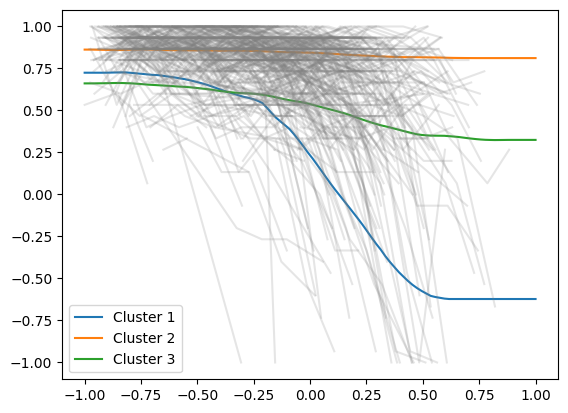

In [60]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(Y_interp)

for k in range(3):
    plt.plot(grid, Y_interp[labels == k].mean(axis=0), label=f"Cluster {k + 1}")

plt.plot(t.T, y.squeeze(-1).T, c="gray", alpha=0.2)

plt.legend()
plt.show()

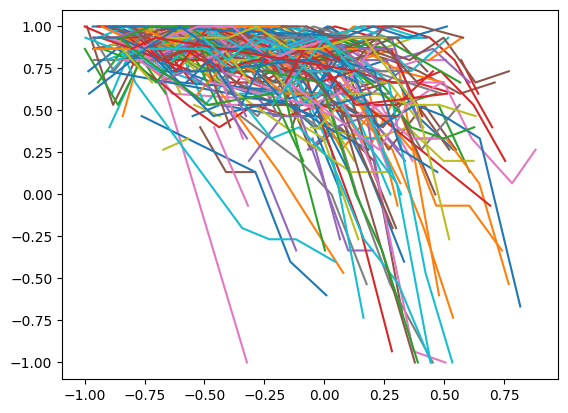

In [61]:
ids = random.sample(range(1, 501), 300)

x, t, y, trajectories, c = prepare_all(ids)

plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [62]:
buckets = build_buckets(trajectories)

In [63]:
def reg(t: torch.Tensor, psi: torch.Tensor):
    a, b, c = psi.chunk(3, dim=-1)
    return (a * torch.tanh((t - c) / b) + (torch.ones(1) - a)).unsqueeze(-1)


def f(gamma: torch.Tensor | None, x: torch.Tensor | None, b: torch.Tensor):
    psi = cast(torch.Tensor, gamma) + b
    psi[..., 0] = psi[..., 0].sigmoid()
    psi[..., 1] = -psi[..., 1].exp()
    return psi


surv = {key: (jmstate.functions.Exponential(1.0), reg) for key in buckets}

init_alphas = {key: torch.zeros(1) for key in buckets}
init_betas = {key: torch.zeros(2) for key in buckets}

init_params = ModelParams(
    torch.zeros(3),
    repr_from_cov(torch.eye(3), method="full"),
    repr_from_cov(torch.eye(1), method="ball"),
    init_alphas,
    init_betas,
    extra=[p for val in surv.values() for p in val[0].parameters()],
)

model_design = ModelDesign(
    f,
    reg,
    surv,
)

In [64]:
data = ModelData(x, t, y, trajectories, c)

Running joint model: 100%|██████████| 500/500 [00:24<00:00, 20.10it/s]
c:\Users\flhei\Desktop\jmstate-main\jmstate\model\_base.py:434: UserWarning: The parameters are not converged, try increasing the maximum number of iterations, decreasing the learning rate, or increasing n_chains
  job.end(info=info, metrics=metrics)


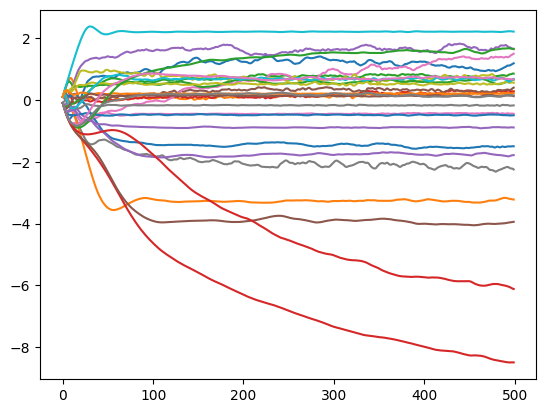

In [65]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        jmstate.jobs.Fit(lr=0.1),
        jmstate.jobs.LogParamsHistory(),
        jmstate.jobs.ParamStop(),
    ],
    max_iterations=500,
)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [66]:
print(model.params_)
model.params_.get_cov("Q")

ModelParams(gamma=tensor([1.1850, 0.2830, 0.8495]), Q_repr=MatRepr(flat=tensor([ 0.2686,  1.6420,  0.3970,  1.4968, -2.2502,  0.6401]), dim=3, method='full'), R_repr=MatRepr(flat=tensor([2.2103]), dim=1, method='ball'), alphas={(1, 2): tensor([-1.4997]), (2, 3): tensor([-3.2235]), (0, 1): tensor([0.6667]), (0, 3): tensor([-8.4932]), (0, 2): tensor([-1.7848]), (1, 3): tensor([-3.9441])}, betas={(1, 2): tensor([-0.4472, -0.1773]), (2, 3): tensor([0.5545, 0.6745]), (0, 1): tensor([-0.4972,  0.2082]), (0, 3): tensor([ 1.6533, -6.1179]), (0, 2): tensor([-0.8923,  0.1214]), (1, 3): tensor([0.6640, 0.1439])})


tensor([[ 3.8706, -1.8472, -0.8459],
        [-1.8472,  1.0883,  0.4205],
        [-0.8459,  0.4205,  0.2780]])

tensor([1.1850, 0.2830, 0.8495])


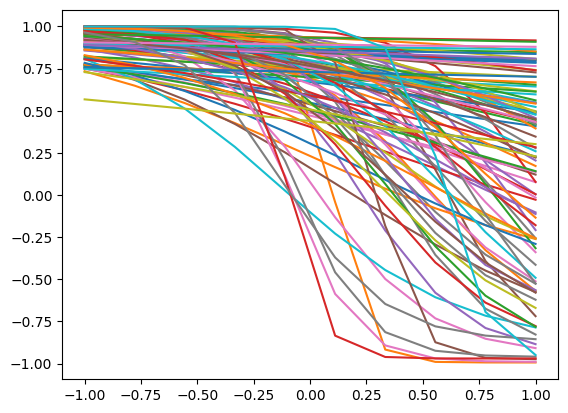

In [67]:
n_test = 100
t_test = torch.linspace(-1, 1, 10)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(3), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1), model.params_.get_cov("R")
)

x_test = x[:n_test]
b_test = Q_dist.sample((n_test,))
psi_test = model_design.individual_effects_fn(model.params_.gamma, x_test, b_test)
trajectories_init_test = [[trajectories[i][0]] for i in range(n_test)]
print(model.params_.gamma)
y_test = model_design.regression_fn(t_test, psi_test)
y_test += 0 * R_dist.sample(y_test.shape[:-1])
plt.plot(t_test, y_test[:, :, 0].T)
plt.show()

In [68]:
sample_data_test = SampleData(x_test, trajectories_init_test, psi_test)
trajectories_test = model.sample_trajectories(
    sample_data_test, torch.full((len(trajectories_init_test), 1), 1.0)
)